In [2]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
import math
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline

/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [8]:
dates_list = ['2408', '2708', '2908','0309', '0609']
#dates_list = [ '2408', '2708']#'0609']
#dates_list = [ '0309', '0609']
#exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']
exps = ['AER', 'AEUR','AENR10', 'AENUR10', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']
#exps = ['AER','AENR10', 'AENUR10']

exp_data = dict()

for date in dates_list:
    exp_data.update({date:{'AER': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/R/log/log.log',
                                   'label': 'Rotated',
                                    'plot':['#fa8174', '-']},
        'AEUR': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/UR/log/log.log',
                 'label': 'Unrotated',
                 'plot': ['c','--']},
        'AENR10':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N10NR/log/log.log',
                  'label': 'Noisy 10 Rotated',
                 'plot':['m','-']},
        'AENUR10': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N10NUR/log/log.log',
                    'label': 'Noisy 10 Unrotated',
                 'plot':['g','--']},
        'AENR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N25NR/log/log.log',
                  'label': 'Noisy 25 Rotated',
                 'plot':['k','-']},
        'AENUR25': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N25NUR/log/log.log',
                    'label': 'Noisy 25 Unrotated',
                 'plot':['b','--']},
        'AENR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N50NR/log/log.log',
                  'label': 'Noisy 50 Rotated',
                 'plot':['y','-']},
        'AENUR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N50NUR/log/log.log',
                   'label': 'Noisy 50 Unrotated',
                 'plot':['#8A2BE2','--']},
            }
        })
    
    for exp in exps:
        e = LearningCurve(exp_data[date][exp]['log'])
        e.parse()
        for phase in [Phase.TRAIN, Phase.TEST]:
            exp_data[date][exp][phase] = {}
            exp_data[date][exp][phase]['num_iter'] = e.list('NumIters', phase)
            exp_data[date][exp][phase]['cross_entropy_loss'] = e.list('cross_entropy_loss', phase)
            
#Extract Test accuracy and Trains loss over groups
loss = [[] for e in exps]

for d,_ in exp_data.items():
    for i,e in enumerate(exps):
        loss[i].append(exp_data[d][e][Phase.TRAIN]['cross_entropy_loss'])
        
    

(0, 'AER')
(1, 'AEUR')
(2, 'AENR10')
(3, 'AENUR10')
(4, 'AENR25')
(5, 'AENUR25')
(6, 'AENR50')
(7, 'AENUR50')


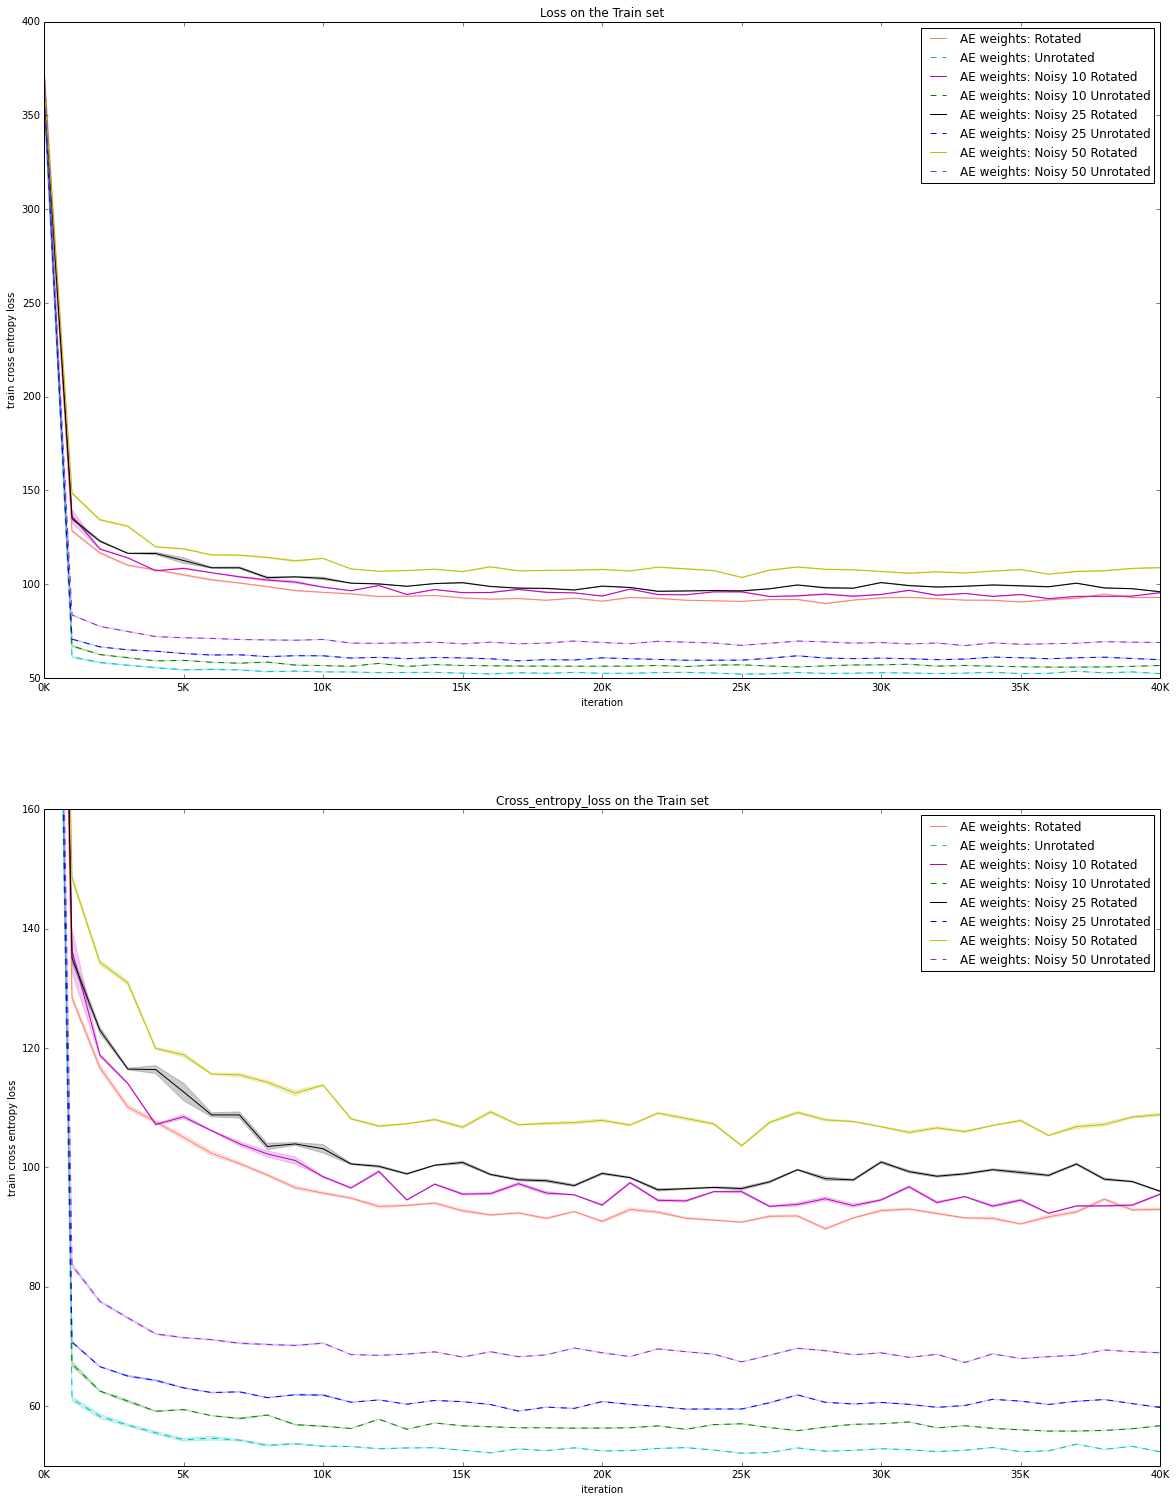

In [22]:
fig = plt.figure(figsize=(20,40))
xmax = 39000
ymin = 0.7
ymax = 0.96
fix_date = dates_list[0]
num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
for i,e in enumerate(exps):
    print(i,e)

    
    
    plt.subplot(3,1,1)
    ma = np.mean(loss[i], axis = 0).squeeze()
    mstd = np.std(loss[i], axis = 0).squeeze()
    num_iter = exp_data[fix_date]['AER'][Phase.TRAIN]['num_iter']
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=exp_data[fix_date][e]['plot'][0], linestyle = exp_data[fix_date][e]['plot'][1])
    plt.fill_between(num_iter.squeeze(), ma-1*mstd, ma+1*mstd,  color=exp_data[fix_date][e]['plot'][0], alpha=0.2)
    plt.xlim(0,xmax)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train cross entropy loss')
    plt.title("Loss on the %s set" % ('Train'))
    plt.legend()
    
    plt.subplot(3,1,2)
    ma = np.mean(loss[i], axis = 0).squeeze()
    mstd = np.std(loss[i], axis = 0).squeeze()
    num_iter = exp_data[fix_date]['AER'][Phase.TRAIN]['num_iter']
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=exp_data[fix_date][e]['plot'][0], linestyle = exp_data[fix_date][e]['plot'][1])
    plt.fill_between(num_iter.squeeze(), ma-1*mstd, ma+1*mstd,  color=exp_data[fix_date][e]['plot'][0], alpha=0.2)
    plt.xlim(0,xmax)
    plt.ylim(50,160)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train cross entropy loss')
    plt.title("Cross_entropy_loss on the %s set" % ('Train'))
    plt.legend()


plt.show()